In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"letmlytt","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c generated-or-not

!unzip generated-or-not.zip

 95%|██████████████████████████████████████▊  | 328M/346M [00:01<00:00, 296MB/s]
100%|█████████████████████████████████████████| 346M/346M [00:01<00:00, 280MB/s]
Archive:  generated-or-not.zip
  inflating: images/01SPjdJuM4.jpg   
  inflating: images/01a7MiLURN.jpg   
  inflating: images/05q5J7VWr4.png   
  inflating: images/0666kmCAAC.jpeg  
  inflating: images/07aHL0dVg4.jpg   
  inflating: images/09Egy0VfTa.jpeg  
  inflating: images/0HBgVT0VvK.png   
  inflating: images/0IE6GFg13M.jpg   
  inflating: images/0OOMZGDyV8.jpg   
  inflating: images/0R1JRbHS33.jpeg  
  inflating: images/0SSwUAl04C.png   
  inflating: images/0XXH9LDP1C.jpg   
  inflating: images/0XbpHcAqVo.jpg   
  inflating: images/0XftCQbfAl.jpg   
  inflating: images/0Y1MAVdEa5.jpg   
  inflating: images/0a1KuiILS4.jpg   
  inflating: images/0aj2WnLarN.jpg   
  inflating: images/0bAvf1FcUP.jpeg  
  inflating: images/0fNsR1ONLv.jpg   
  inflating: images/0gbbtcW2lP.jpg   
  inflating: images/0kX8W174U6.png   
  inflati

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

train_df = pd.read_csv("/kaggle/working/train.csv")
test_df = pd.read_csv("/kaggle/working/test.csv")

print("train info: \n",train_df.head())
print("\n\ntest info: \n",test_df.head())

train info: 
                 id  target
0   gL5fWrgNPU.jpg       0
1   KKWXJDN8uM.png       1
2   Wb2I0CXlAY.jpg       0
3  G7PLhKpaf7.jpeg       1
4   DEUkeefz6Z.jpg       0


test info: 
                 id
0  Qt1fGUB0Vz.jpeg
1  j4Rhioq7R3.jpeg
2  rD0hgFHJUZ.jpeg
3  aY5z1EJsJ6.jpeg
4  qZ3IoxD2TE.jpeg


In [67]:
img_names = os.listdir('/kaggle/working/images/')
repaired_train_df = pd.DataFrame(columns=['id', 'target'])
repaired_test_df = pd.DataFrame(columns=['id'])

for rep_df, chosen_df in zip([repaired_train_df, repaired_test_df], [train_df, test_df]):
    for row in chosen_df.itertuples():
        name_ext = row.id.split('.')
        img_name_ = [img_name for img_name in img_names if img_name.split('.')[0] == name_ext[0]][0]
        ins_val = [img_name_, row.target] if 'target' in chosen_df else [img_name_]
        rep_df.loc[len(rep_df)] = ins_val

In [68]:
print(repaired_train_df.head())
print(repaired_test_df.head())

                id  target
0   gL5fWrgNPU.jpg       0
1   KKWXJDN8uM.png       1
2   Wb2I0CXlAY.jpg       0
3  G7PLhKpaf7.jpeg       1
4   DEUkeefz6Z.jpg       0
                id
0  Qt1fGUB0Vz.jpeg
1  j4Rhioq7R3.jpeg
2  rD0hgFHJUZ.jpeg
3  aY5z1EJsJ6.jpeg
4  qZ3IoxD2TE.jpeg


In [87]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_target=True):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform        
        self.is_target = is_target


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['id'])
        image = image = Image.open(img_name).convert("RGB")
        if self.is_target:
            label = torch.tensor(self.dataframe.iloc[idx]['target']).float()  # Метка класса
        else:
            label = 0
        if self.transform:
            image = self.transform(image)
        return image, label

In [70]:
from sklearn.model_selection import train_test_split

# Трансформации данных
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

X, y = train_test_split(repaired_train_df, test_size = 0.25, random_state = 42)
print(X.head())

img_dir = '/kaggle/working/images/'
# Создание датасетов
train_ds = CustomImageDataset(dataframe=X, img_dir=img_dir, transform=transform)
test_ds = CustomImageDataset(dataframe=y, img_dir=img_dir, transform=transform)

# Создание DataLoader
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

                  id  target
359  0bAvf1FcUP.jpeg       1
82    HB2iZDv8M5.jpg       0
256   YbtiC2Mq0z.jpg       0
352  xZMbkaJjau.jpeg       1
370   n48BfEKsJR.jpg       0


In [71]:
# Загрузка предобученной модели ResNet-18
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Убираем последний полносвязный слой

        # MLP часть
        self.mlp = nn.Sequential(
            nn.LayerNorm(num_ftrs),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.mlp(x)
        return x

# Создание модели
model = ModifiedResNet()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
model = ModifiedResNet().to('cuda')

In [74]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 40
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')  # Перенос данных на GPU
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Сохранение модели
torch.save(model.state_dict(), 'modified_resnet18_model.pth')

Epoch [1/40], Loss: 0.3445
Epoch [2/40], Loss: 0.3073
Epoch [3/40], Loss: 0.2787
Epoch [4/40], Loss: 0.2236
Epoch [5/40], Loss: 0.2393
Epoch [6/40], Loss: 0.1399
Epoch [7/40], Loss: 0.1913
Epoch [8/40], Loss: 0.1912
Epoch [9/40], Loss: 0.1886
Epoch [10/40], Loss: 0.1774
Epoch [11/40], Loss: 0.0859
Epoch [12/40], Loss: 0.0981
Epoch [13/40], Loss: 0.2645
Epoch [14/40], Loss: 0.1451
Epoch [15/40], Loss: 0.1229
Epoch [16/40], Loss: 0.0894
Epoch [17/40], Loss: 0.1318
Epoch [18/40], Loss: 0.1152
Epoch [19/40], Loss: 0.0626
Epoch [20/40], Loss: 0.0665
Epoch [21/40], Loss: 0.0664
Epoch [22/40], Loss: 0.0641
Epoch [23/40], Loss: 0.0361
Epoch [24/40], Loss: 0.0308
Epoch [25/40], Loss: 0.0524
Epoch [26/40], Loss: 0.0577
Epoch [27/40], Loss: 0.0822
Epoch [28/40], Loss: 0.0575
Epoch [29/40], Loss: 0.0973
Epoch [30/40], Loss: 0.0330
Epoch [31/40], Loss: 0.0287
Epoch [32/40], Loss: 0.1126
Epoch [33/40], Loss: 0.0475
Epoch [34/40], Loss: 0.0485
Epoch [35/40], Loss: 0.0354
Epoch [36/40], Loss: 0.0379
E

In [75]:
# Тестирование модели
def test_model(test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

In [77]:
test_model(test_loader)

Accuracy: 89.33%


### тест на выборке соревнования

In [104]:
submit = pd.DataFrame(columns=['id'])
submit['id'] = test_df['id']
img_test_ds = CustomImageDataset(dataframe=repaired_test_df, img_dir=img_dir, transform=transform, is_target=False)
SUBMIT_loader = DataLoader(img_test_ds, batch_size=32, shuffle=False)

def make_submit(df, sub_df):
    predicts = np.array([])
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in df:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs).squeeze()
            outputs.to('cpu')
            predicts = np.concatenate([predicts ,outputs.clone().detach().cpu().numpy()])
            
    sub_df.insert(1, 'target', predicts)
    sub_df.to_csv('/kaggle/working/submit.csv')

make_submit(SUBMIT_loader, submit)
            

In [105]:
submit.to_csv('/kaggle/working/submit.csv', index=False)

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/modified_resnet18_model.pth', 'model')

### Тест на другом датасете

In [106]:
REAL_imgs_names = os.listdir('/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt')

REAL_imgs_df = pd.DataFrame(data=({'id':REAL_imgs_names, 'target':[0] * len(REAL_imgs_names)}))

In [107]:
REAL_imgs_df.head()

,id,target
0,Various-AI-portraits-generated-by-Fotor.jpg,1
1,images77.jpg,1
2,1000_F_563719058_JXnzcPV4GRpWqmF5sqnqmbJ7ow3ca...,1
3,MidJourney-content-policy-1024x576.jpg,1
4,an-ai-jungle-landscape-made-by-ai-landscape-ge...,1


In [108]:
real_dir = '/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt'

REAL_test_ds = CustomImageDataset(dataframe=REAL_imgs_df, img_dir=real_dir, transform=transform)
REAL_test_loader = DataLoader(REAL_test_ds, batch_size=32, shuffle=False)

In [110]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in REAL_test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on Real_images: {100 * correct / total:.2f}%')

Accuracy on Real_images: 72.71%


### Построю графики фич

In [111]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Убираем последний полносвязный слой

    def forward(self, x):
        return self.resnet(x)

# Инициализация модели
feature_extractor = FeatureExtractor().to('cuda')
feature_extractor.load_state_dict(model.state_dict(), strict=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['mlp.0.weight', 'mlp.0.bias', 'mlp.1.weight', 'mlp.1.bias', 'mlp.3.weight', 'mlp.3.bias', 'mlp.4.weight', 'mlp.4.bias', 'mlp.6.weight', 'mlp.6.bias', 'mlp.7.weight', 'mlp.7.bias'])

In [112]:
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to('cuda')
            outputs = model(inputs)
            features.append(outputs.cpu())
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

In [113]:
def plot_embedding(embedding, labels, title):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='viridis', s=60)
    plt.title(title)
    plt.show()


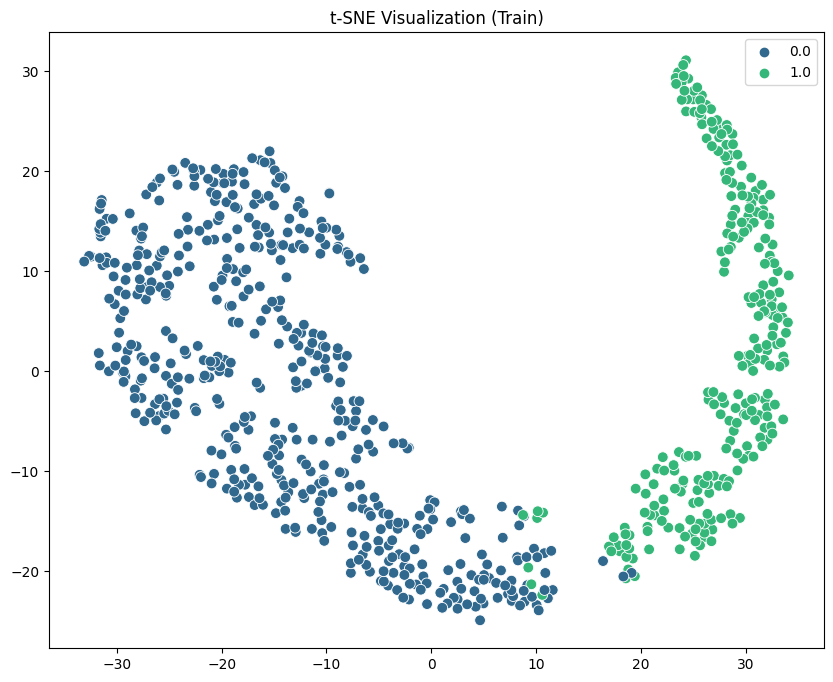

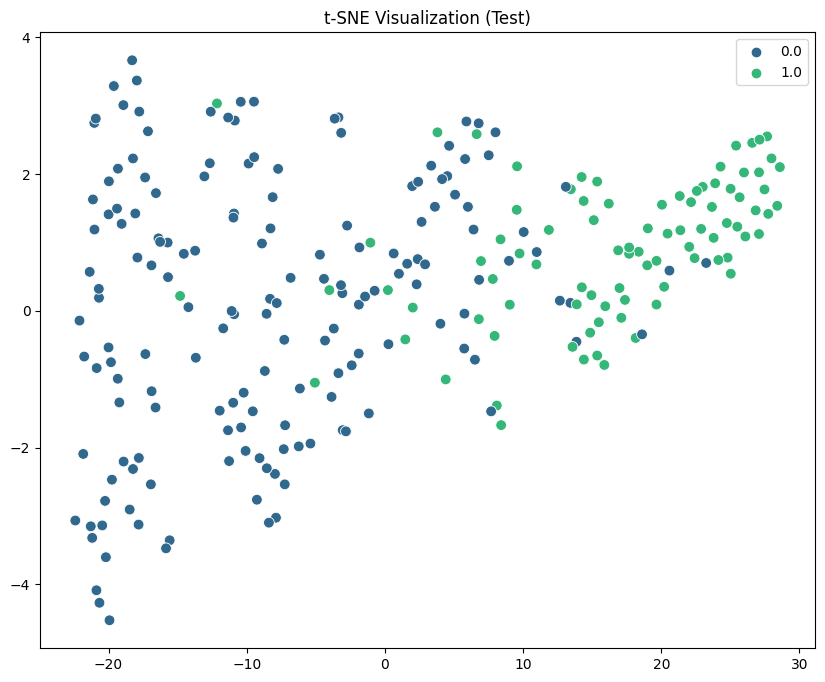

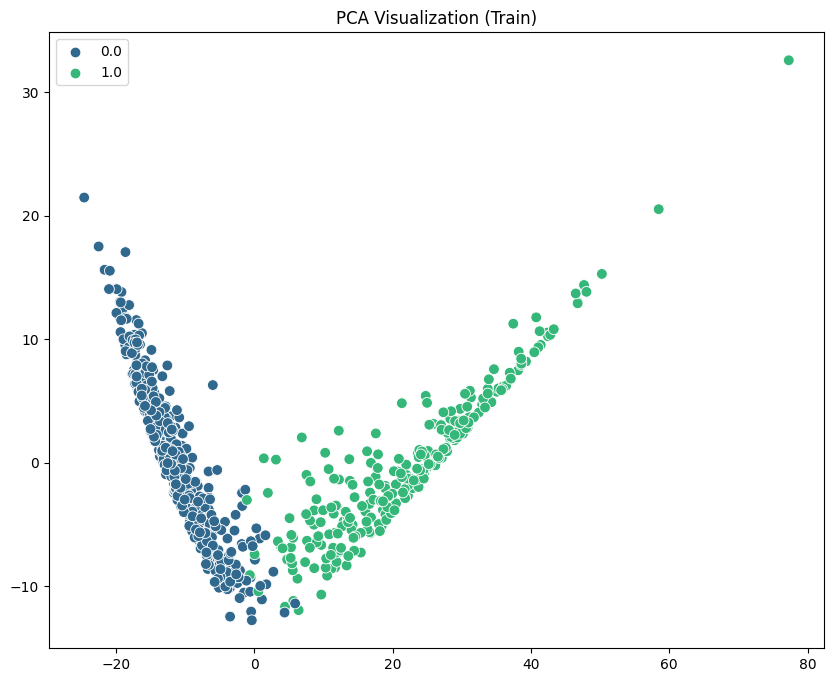

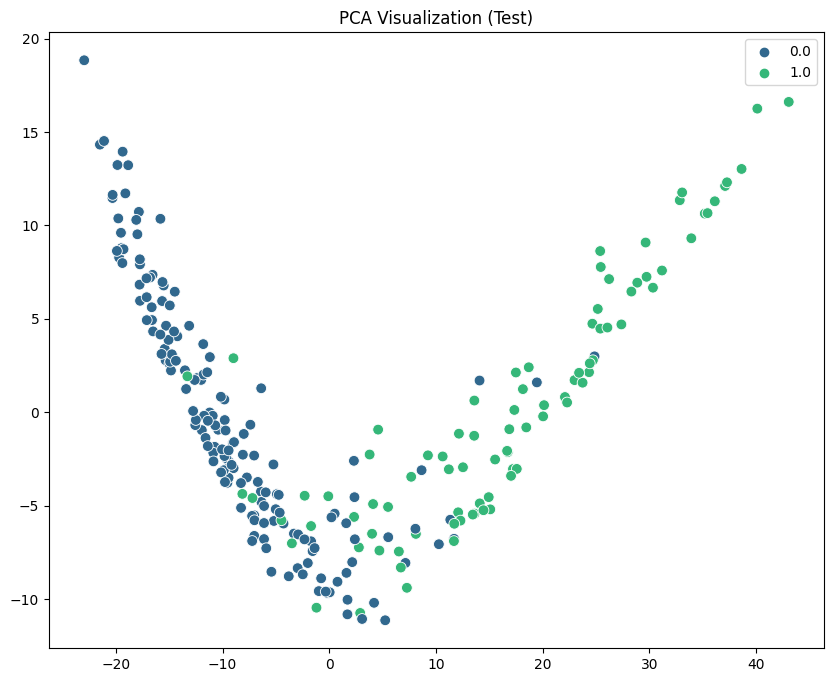

In [114]:
X, y = train_test_split(repaired_train_df, test_size = 0.25, random_state = 42)


# старый датасет
old_train_ds = CustomImageDataset(dataframe=X, img_dir=img_dir, transform=transform)
old_test_ds = CustomImageDataset(dataframe=y, img_dir=img_dir, transform=transform)

# Создание DataLoader
old_train_loader = DataLoader(old_train_ds, batch_size=32, shuffle=True)
old_test_loader = DataLoader(old_test_ds, batch_size=32, shuffle=False)

# Извлекаем признаки из обучающей и тестовой выборок
train_features, train_labels = extract_features(old_train_loader, feature_extractor)
test_features, test_labels = extract_features(old_test_loader, feature_extractor)

# Преобразование признаков в numpy
train_features_np = train_features.numpy()
test_features_np = test_features.numpy()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_features_np)
test_tsne = tsne.fit_transform(test_features_np)

# PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_features_np)
test_pca = pca.fit_transform(test_features_np)

# Построение графиков t-SNE
plot_embedding(train_tsne, train_labels.numpy(), 't-SNE Visualization (Train)')
plot_embedding(test_tsne, test_labels.numpy(), 't-SNE Visualization (Test)')

# Построение графиков PCA
plot_embedding(train_pca, train_labels.numpy(), 'PCA Visualization (Train)')
plot_embedding(test_pca, test_labels.numpy(), 'PCA Visualization (Test)')

### По графикам разделения пространства выделенных фичей картинок у дообученной RESnet можно сказать, что и на train и на test выборке модель отлично поделила пространство